Loading Data...
Initializing optimization for 174 items...
Optimization Complete. Relocated 108 items.

Generating Visualizations...

--- Initial State ---

==================== PROCESSING: Initial State ====================

---------- Initial State ----------
Weight Violations        : 0 (OK)
Misplaced A-Items        : 17 (!)

--- Scoring Breakdown (Avg per Occupied Bin) ---
Avg Combined Score       : 261.0
  > Zone Reward          : 27.6
  > Util Reward          : 285.2
  > Dist Penalty         : -51.8

Avg Util (Occupied)      : 35.65%
%Occupied Bins           : 48.7%   (174/357)
---------------------------------------------

[Visualizer] Plot saved to: /content/plots/plot_029_top_view_initial_state.png


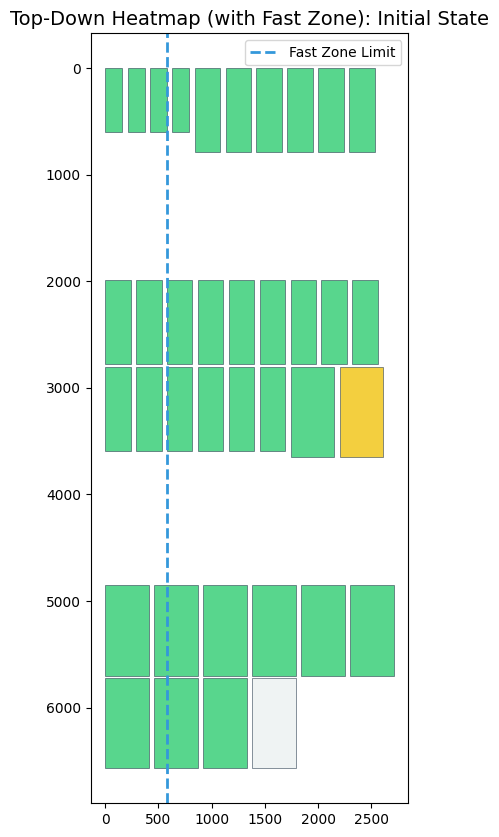

[Visualizer] Plot saved to: /content/plots/plot_030_front_view_initial_state.png


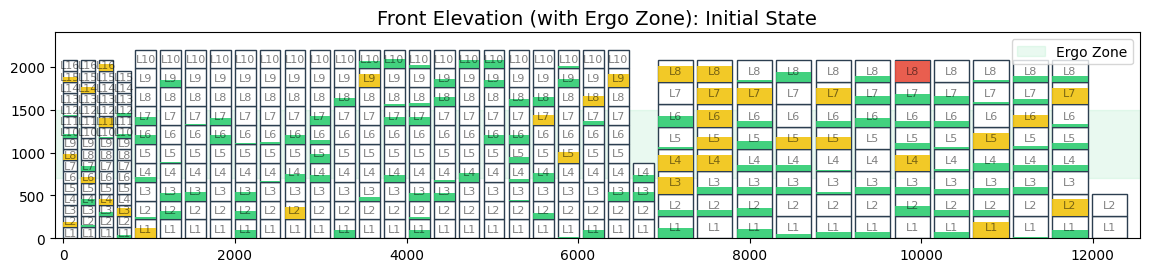

[Visualizer] Plot saved to: /content/plots/plot_031_scatter_demand_height_initial_state.png


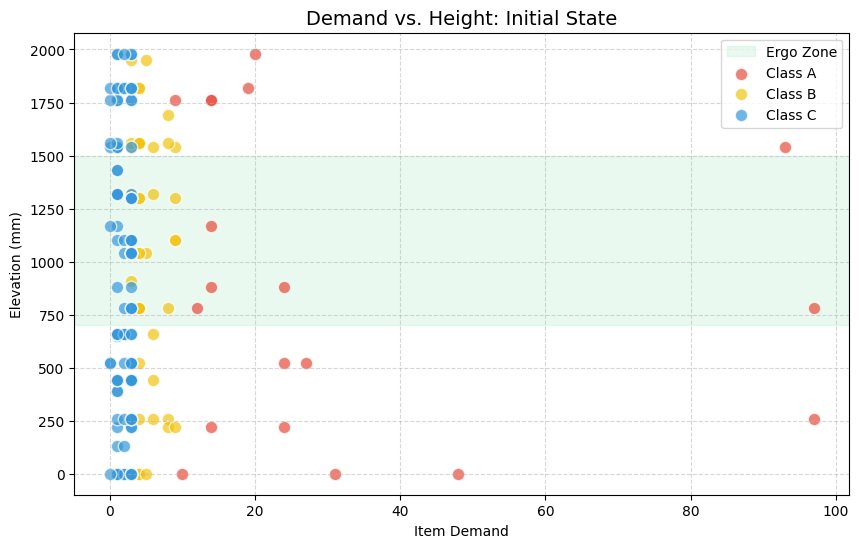

[Visualizer] Plot saved to: /content/plots/plot_032_hist_utilization_initial_state.png


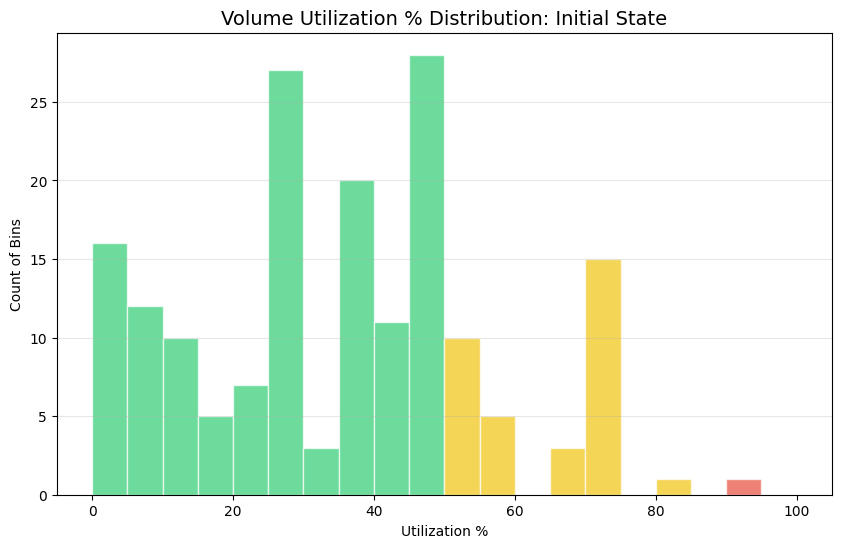


--- Final Optimized State ---

==================== PROCESSING: Final Optimized State ====================

---------- Final Optimized State ----------
Weight Violations        : 0 (OK)
Misplaced A-Items        : 14 (!)

--- Scoring Breakdown (Avg per Occupied Bin) ---
Avg Combined Score       : 293.6
  > Zone Reward          : 54.0
  > Util Reward          : 273.3
  > Dist Penalty         : -33.6

Avg Util (Occupied)      : 34.16%
%Occupied Bins           : 48.7%   (174/357)
---------------------------------------------

[Visualizer] Plot saved to: /content/plots/plot_033_top_view_final_optimized_state.png


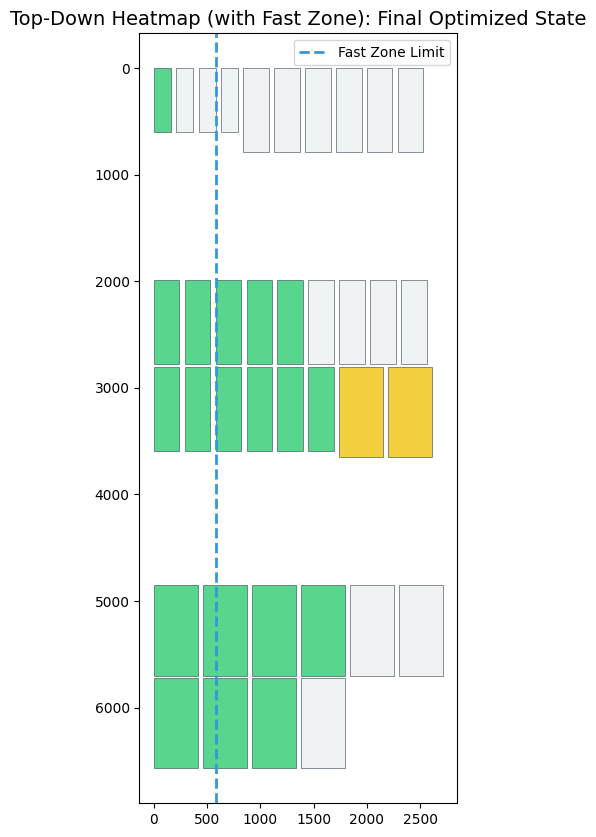

[Visualizer] Plot saved to: /content/plots/plot_034_front_view_final_optimized_state.png


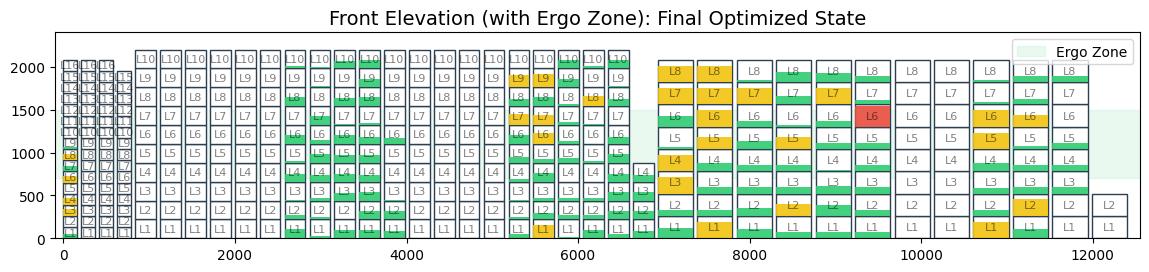

[Visualizer] Plot saved to: /content/plots/plot_035_scatter_demand_height_final_optimized_state.png


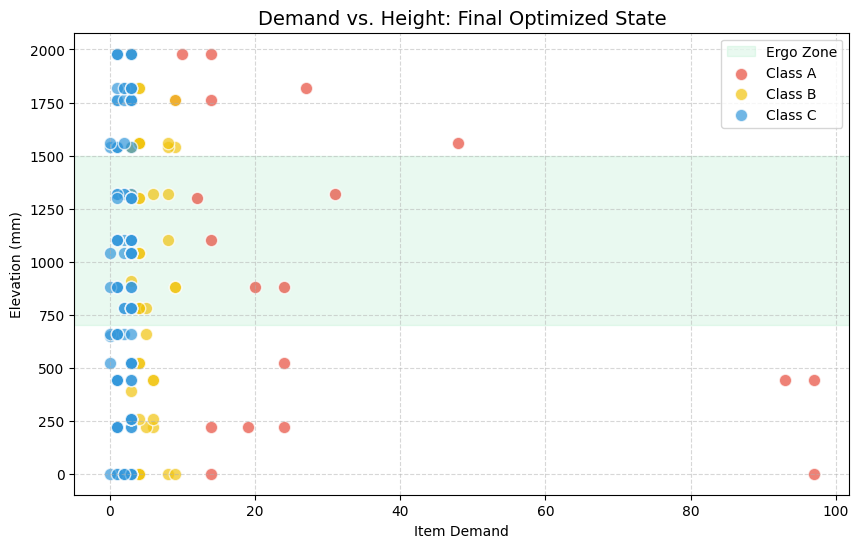

[Visualizer] Plot saved to: /content/plots/plot_036_hist_utilization_final_optimized_state.png


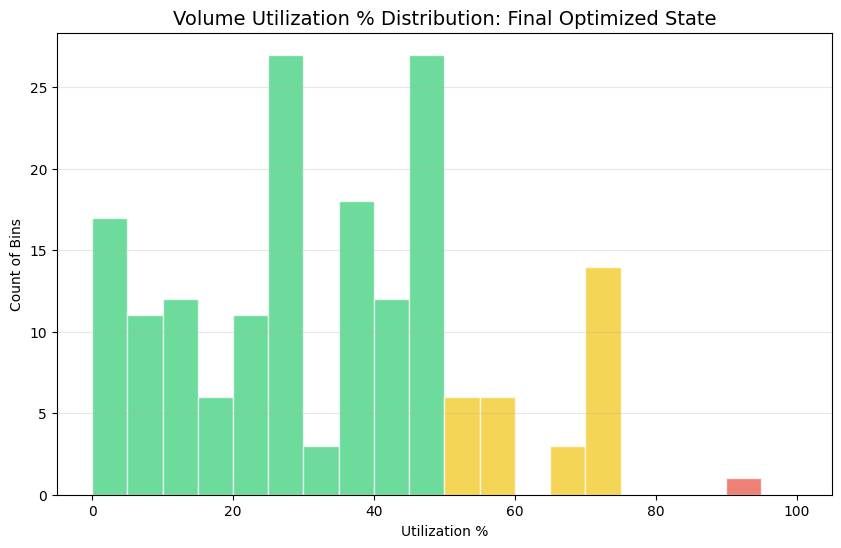

Saved allocations_optimized.csv


In [ ]:
import pandas as pd
import numpy as np
import warnings
import sys
import os
import importlib
from itertools import permutations

# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
sys.path.append(os.getcwd())

try:
    import data_loader as dl
    import geometry as geo
    import metrics_viz_lib as viz
    importlib.reload(dl)
    importlib.reload(geo)
except ImportError as e:
    print(f"Critical Error: {e}")

warnings.filterwarnings('ignore')

# ==========================================
# 2. HEURISTIC ENGINE
# ==========================================
class WarehouseHeuristicEngine:
    def __init__(self, locations, parts_meta):
        self.locations = locations
        self.parts_meta = parts_meta
        xs = [l['POS_X_MM'] for l in locations]
        ys = [l['POS_Y_MM'] for l in locations]
        self.max_x = max(xs) if xs else 0
        self.max_y = max(ys) if ys else 0
        self.entrance_y = self.max_y / 2

    def calculate_score(self, item_id, loc_dict, part_data):
        score = 0
        abc = part_data.get('ABC_CLASS', 'C')
        weight = part_data.get('WT_KG', 0)

        # Zone Rewards
        if abc == 'A' and loc_dict['POS_X_MM'] <= (self.max_x * 0.25): score += 500
        if weight > 15 and (700 <= loc_dict['POS_Z_MM'] <= 1500): score += 500

        # Util Reward
        item_vol = part_data['VOLUME_MM3']
        bin_vol = loc_dict['VOLUME_MM3']
        if bin_vol > 0: score += (item_vol / bin_vol) * 1000

        # Distance Penalty
        dist = abs(loc_dict['POS_X_MM']) + abs(loc_dict['POS_Y_MM'] - self.entrance_y)
        score -= (dist * 0.1)
        return score

    def run_optimization(self, current_alloc_df):
        print(f"Initializing optimization for {len(current_alloc_df)} items...")
        df_optimized = current_alloc_df.copy()

        # Identify pools
        occupied_ids = set(df_optimized['loc_inst_code'].unique())
        empty_locations_pool = [l for l in self.locations if l['LOCATION_ID'] not in occupied_ids]

        # Prepare and Sort Items (A -> B -> C)
        items_to_process = []
        for idx, row in df_optimized.iterrows():
            item_id = row['ITEM_ID']
            if item_id in self.parts_meta:
                meta = self.parts_meta[item_id]
                items_to_process.append({'idx': idx, 'row': row, 'meta': meta, 'abc': meta.get('ABC_CLASS', 'C')})

        items_to_process.sort(key=lambda x: {'A':0, 'B':1, 'C':2}.get(x['abc'], 2))

        count_moved = 0

        for item_obj in items_to_process:
            idx = item_obj['idx']
            row = item_obj['row']
            meta = item_obj['meta']
            qty = row['QTY_ALLOCATED']

            curr_loc_id = row['loc_inst_code']
            curr_loc = next((l for l in self.locations if l['LOCATION_ID'] == curr_loc_id), None)

            if not curr_loc: continue
            current_score = self.calculate_score(row['ITEM_ID'], curr_loc, meta)

            # Find Candidate
            best_bin = None
            best_score = -float('inf')
            best_geom_data = None

            sku_dims = [meta['LEN_MM'], meta['WID_MM'], meta['DEP_MM']]

            for candidate in empty_locations_pool:
                # --- GEOMETRY CHECK ---
                # Returns: max_units, (sx, sy, sz), (nx, ny, nz)
                max_units, orientation, grid = geo.compute_layered_capacity(candidate['DIMS_MM'], sku_dims)

                # STRICT CONSTRAINT: Must fit allocated qty
                if max_units < qty: continue

                # STRICT CONSTRAINT: Ensure Grid * Orientation <= Bin Dims (The Validator Check)
                bin_w, bin_d, bin_h = candidate['DIMS_MM']
                ox, oy, oz = orientation
                nx, ny, nz = grid
                if (nx * ox > bin_w) or (ny * oy > bin_d) or (nz * oz > bin_h):
                    continue # Floating point safety skip

                # --- SAFETY CHECK ---
                if meta['WT_KG'] > 15 and candidate['POS_Z_MM'] > 1500: continue

                # --- SCORE ---
                score = self.calculate_score(row['ITEM_ID'], candidate, meta)

                if score > best_score:
                    best_score = score
                    best_bin = candidate
                    best_geom_data = (max_units, orientation, grid) # Save Grid!

            # Execute Move
            if best_bin and best_score > (current_score + 5):
                # 1. Update Core Allocation
                df_optimized.at[idx, 'loc_inst_code'] = best_bin['LOCATION_ID']

                # 2. UPDATE GEOMETRY (The Fix for Validation)
                new_max, new_orient, new_grid = best_geom_data

                df_optimized.at[idx, 'MAX_UNITS'] = new_max

                # Update Orientation
                ox, oy, oz = new_orient
                df_optimized.at[idx, 'ORIENT_X_MM'] = ox
                df_optimized.at[idx, 'ORIENT_Y_MM'] = oy
                df_optimized.at[idx, 'ORIENT_Z_MM'] = oz

                # Update Grid (Essential for Stack Validation)
                gx, gy, gz = new_grid
                df_optimized.at[idx, 'GRID_X'] = gx
                df_optimized.at[idx, 'GRID_Y'] = gy
                df_optimized.at[idx, 'GRID_Z'] = gz

                # Update Utilization
                total_item_vol = meta['VOLUME_MM3'] * qty
                new_bin_vol = best_bin['VOLUME_MM3']
                new_util = (total_item_vol / new_bin_vol) * 100 if new_bin_vol > 0 else 0
                df_optimized.at[idx, 'UTILIZATION_PCT'] = round(new_util, 2)

                # Update Volume Metadata for Validation Check
                df_optimized.at[idx, 'LOCATION_VOL_MM3'] = new_bin_vol
                # Convert to M3 for consistency if needed, assuming validation checks MM3

                # Swap Pools
                empty_locations_pool.remove(best_bin)
                empty_locations_pool.append(curr_loc)
                count_moved += 1

        print(f"Optimization Complete. Relocated {count_moved} items.")
        return df_optimized

# ==========================================
# 3. EXECUTION
# ==========================================
print("Loading Data...")
_, part_meta, locations, _, _ = dl.load_data()
df_alloc = pd.read_csv('allocations.csv')

# Explicitly ensure numeric types to prevent string errors
numeric_cols = ['QTY_ALLOCATED', 'MAX_UNITS', 'GRID_X', 'GRID_Y', 'GRID_Z', 'ORIENT_X_MM', 'ORIENT_Y_MM', 'ORIENT_Z_MM', 'UTILIZATION_PCT', 'LOCATION_VOL_MM3']
for col in numeric_cols:
    if col in df_alloc.columns:
        df_alloc[col] = pd.to_numeric(df_alloc[col], errors='coerce').fillna(0)

# Run Optimization
engine = WarehouseHeuristicEngine(locations, part_meta)
df_final = engine.run_optimization(df_alloc)

# --- VISUALIZATION ---
print("\nGenerating Visualizations...")

# Load viz data explicitly (for the library compatibility)
df_locs_viz = pd.read_csv('locations_dummy.csv')
df_items_viz = pd.read_csv('synthetic_parts_generated_dummy.csv', sep=';')

# Initial State Visualization
print("\n--- Initial State ---")
viz.generate_dashboard(df_alloc, df_locs_viz, df_items_viz, title="Initial State")

# Final Optimized State Visualization
print("\n--- Final Optimized State ---")
viz.generate_dashboard(df_final, df_locs_viz, df_items_viz, title="Final Optimized State")

# Save
df_final.to_csv('allocations_optimized.csv', index=False)
print("Saved allocations_optimized.csv")